# Setup

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, \
                                        Lambda, GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

plt.style.use('ggplot')

In [ ]:
len(os.listdir('data/ext/train/'))

35122

# Hyperprameters

In [ ]:
IMAGE_SIZE = 150
ALPHA = 0.4
BASE_MODEL = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# CLASSIFIER = tf.keras.models.load_model("models/model2/model_b.h5")
CLASSIFIER = tf.keras.models.load_model("models/model1/model1.h5")

171446536/171446536 [==============================] - 1s 0us/step


# Data

In [ ]:
data = pd.read_csv("data/ext/trainlabels.csv")

data = data.groupby('level').apply(lambda x: x.sample(2, replace=True, random_state=128)).reset_index(drop=True)

data_path = "data/ext/train"
data_images = [data_path + "/" + i + ".jpeg" for i in data['image']]

data_labels = data['level']

###############################################################################
print("labeled data images", len(data_images))
print("labeled data labels", len(data_labels))

nsample = 5

print(data_images[nsample], data_labels[nsample])

print(data.iloc[nsample, :])

print('Number of classes', len(data_labels.unique()))

labeled data images 10
labeled data labels 10
data/ext/train/19406_right.jpeg 2
image    19406_right
level              2
Name: 5, dtype: object
Number of classes 5


# GRAD CAM

In [ ]:
def make_grad_model(feature_extractor, classifier):
  inputs = feature_extractor.inputs
  features = feature_extractor(inputs)
  x = Flatten()(features)
  predictions = classifier(x)
  model = Model([inputs], [features, predictions])
  return model

In [ ]:
def make_gradcam_heatmap(img_array, pred_index=None):

  grad_model = make_grad_model(BASE_MODEL, CLASSIFIER)

  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)

    if pred_index is None:
        pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]

  grads = tape.gradient(class_channel, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap[0]

In [ ]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img

    return superimposed_img

# Displaying GRAD CAM Results

<ipython-input-9-9ac98d145e4b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


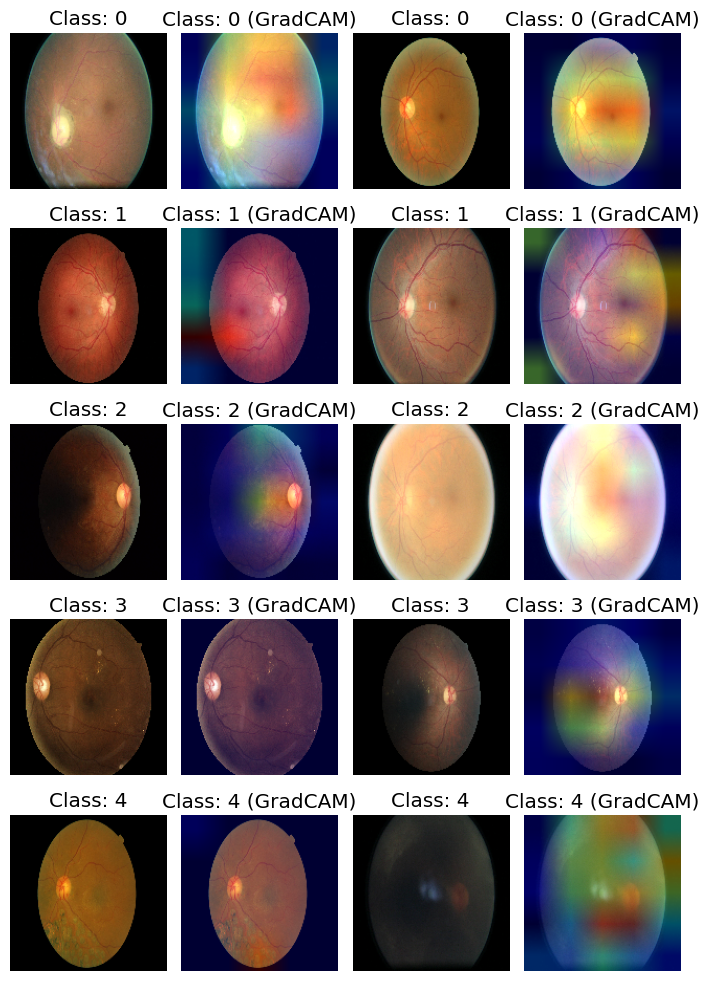

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(7, 10))

for idx, (img_path, label) in enumerate(zip(data_images, data_labels)):
    img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    row = label
    col = (idx % 2) * 2

    # Original image
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Class: {label}")
    axes[row, col].axis('off')

    # GradCAM image
    heatmap = make_gradcam_heatmap(img_array)
    superimposed_img = display_gradcam(img_path, heatmap, alpha=ALPHA)
    superimposed_img_resized = cv2.resize(superimposed_img, (IMAGE_SIZE, IMAGE_SIZE))
    axes[row, col + 1].imshow(superimposed_img_resized / 255)
    axes[row, col + 1].set_title(f"Class: {label} (GradCAM)")
    axes[row, col + 1].axis('off')

plt.tight_layout()
plt.show()